<a href="https://colab.research.google.com/github/ykato27/PyTorch-Audio/blob/main/7_7_speech_command_recognition_with_torchaudio_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

「tourchaudioを用いた音声コマンド認識ニューラルネットワークの構築」
======
【原題】SPEECH COMMAND RECOGNITION WITH TORCHAUDIO

【元URL】https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html#importing-the-dataset

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　大串 和正

【日付】2021年4月17日

【チュトーリアル概要】<br>
``torchaudio``を使い、ニューラルネットワークを構築、訓練し音声コマンドを認識します。

---




本チュートリアルでは音声データセットを正しく構成する方法とそのデータセットを用いて音声分類ネットワークを訓練・テストする方法を紹介します。



ColabではGPUを使うオプションがあります。

メニュータブの"ランタイム"の中の"ランタイムのタイプを変更"を選択してください。

ポップアップが表示されるので、GPUを選択することができます。

変更後ランタイムは自動で再起動されます(実行済みセルの情報は消去されます)。

<br>

（日本語訳注：この日本語チュートリアルではGPUを使用したGoogle Colabでの実行を想定し、既にランタイムのタイプをGPUにしています）


最初に、共通で使用する[torchaudio](https://github.com/pytorch/audio)などのパッケージをインポートします。

パッケージのインストール方法は次のセルのコメントを参照してください。



In [1]:
%matplotlib inline

In [2]:
# Google Colabで実行するには以下の行をアンコメントしてください

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchaudio

# 本チュートリアルの最後にあるデモ実行に必要:
!pip install pydub

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

     |████████████████████████████████| 1.9 MB 5.6 MB/s 


CUDA GPUが利用可能か確認し、デバイスの設定をします。

GPU上でネットワークを実行することで訓練/テストの実行時間が大幅に短縮されます。


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 日本語訳注：cudaと出力されればOKです

cuda


データセットのインポート
---------------------

torchaudioを使ってデータセットをダウンロードし、使えるように準備します。

本チュートリアルでは、[``SpeechCommands``](https://arxiv.org/abs/1804.03209)を使用します。

このデータセットは様々な人物によって発話された35個の命令から構成されています。

``SPEECHCOMMANDS``はこのデータセットの``torch.utils.data.Dataset``版となります。

各データの音声の長さはおよそ1秒 (従って約16000フレーム) です。




実際のデータ読み込みと整形は、データポイントへアクセスした時点から始まり、torchaudioは音声データファイルをテンソルへ変換処理します。


代わりに音声ファイルを直接読み込む場合は、``torchaudio.load()``を使います。

この関数は新しく作成されたテンソルと音声データのサンプリング周波数 (SpeechCommandsの場合は16kHz) のタプルを返します。

今回はデータセットを標準的な訓練、検証、テストのサブセットに分割するサブクラスを実装します。


In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# 訓練セットとテストセットを作成。本チュートリアルでは検証セットは使用しません。。
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

SPEECHCOMMANDSデータセットの各データは、波形データ(音声信号)、サンプリングレート、命令(ラベル)、話者のID、発話数からなるタプルになっています。



Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


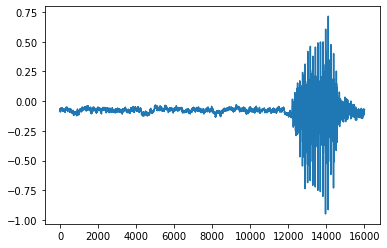

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

データセットに含まれるラベルの一覧を確認します。



In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

この35個の音声データラベルはユーザーに発話されたコマンドです。

最初の数ファイルではコマンドのなかでも「marvin」と発話されています。

<br>

（日本語訳注1：marvinはおそらく、お腹がすいたという意味でしょうか。。。）

（日本語訳注2：2021年4月13日現在、最初の数ファイルの内容は「marvin」ではなく「backward」となっています）


In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

最後のファイルでは「visual」と発話されています。

（日本語訳注：2021年4月13日現在、「zero」となっています）



In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

データの整形
-------------------

データへ変換を適用します。

波形データをダウンサンプルすることにより、分類性能を大きく下げること無く処理を高速化できます。

今回はその他の変換を適用する必要はありません。

<br>

データセットによっては、チャンネルの次元に沿って平均値を計算する、あるいは単純に一つのチャンネルの値だけを使うなどの方法でチャンネル数の削減(例えばステレオからモノラルへの変換)が適用されます。

SpeechCommandsの音声データは1チャンネルだけなので、この操作は今は必要ありません。


In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

ラベルのリストのインデックスを使って各単語をエンコードします。

<br>
(日本語訳注)

すなわち、インデックスの数字からラベル名を求めるリストを用意します。



In [10]:
def label_to_index(word):
    # labelsにおける単語のインデックスを返す
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # labelsのインデックスに対応した単語を返す
    # label_to_indexの逆の作用
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


録音データとコマンド命令から構成されたリスト型の各データを、モデル訓練のために2つのバッチ化されたテンソル（録音データのテンソルのバッチと、コマンド命令のテンソルのバッチ）へ変換するために、collate関数を実装します。

<br>

このcollate関数はPyTorchのデータローダで使用され、バッチ単位でデータセットをイテレートできるようになります。


collate関数の詳しい使い方は[ドキュメント](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)を御覧ください。

今回、collate関数ではリサンプリングと単語のエンコードも行わせます。


In [11]:
def pad_sequence(batch):
    # ゼロ埋めによりバッチに含まれる全てのテンソルを同じ長さにする
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # データタプルは次の形式をとる:
    #  waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # リストにまとめ、ラベルをインデックスでエンコードする
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # テンソルのリストをまとめてバッチ化されたテンソルにする
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

ネットワークの定義
------------------

本チュートリアルでは生の音声データの処理に畳み込みニューラルネットワークを使用します。

通常ではより高度な変換が音声データに適用されるのですが、CNNはそのままの音声データを処理できます。


[こちらの論文](https://arxiv.org/pdf/1610.00087.pdf)で説明されているM5ネットワークアーキテクチャに倣ったアーキテクチャを作成します。



生の音声データを処理するモデルで重要なことは第一層のフィルターの受容野の広さです。

ここで構築するモデルの最初のフィルタの長さは80であるため、8kHzでサンプリングされた音声データを処理すると受容野は約10ms(4kHzであれば約20ms)となります。

このサイズは一般的な音声処理アプリケーションで使われる受容野の広さである20msから40msに近い値となっています。


In [12]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

論文で使われている最適化と同様に、重み減衰を0.0001にしたAdamオプティマイザを使用します。

最初に、学習率を0.01にして訓練を行いますが、``scheduler``を使って20エポック経過後0.001に減衰させることにします。

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # 20エポック毎に学習率を1/10に減衰する

ネットワークの訓練とテスト
--------------------------------

モデルを訓練データへ入力し、逆伝播と最適化を行う訓練関数を定義します。

訓練では負の対数尤度を損失とします。

各エポック完了後にネットワークのテストを行い、訓練中に精度がどのように変化するかを確認します。


In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # デバイス上のバッチデータに変換を適用し、モデルへ入力する
        data = transform(data)
        output = model(data)

        # (batch x 1 x n_output)サイズのテンソルの負の対数尤度
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 訓練の統計値をプリントする
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # プログレスバー更新
        pbar.update(pbar_update)
        # 損失を記録する
        losses.append(loss.item())

訓練関数を定義したのでネットワークの精度をテストする関数を定義します。

モデルを``eval()``モードにし、テストデータセットを使って推論を実行します。

``eval()``を実行することによってネットワークの重みは更新されなくなります。

バッチノーマライゼーション層やドロップアウト層など特定の層は訓練時と推論時で異なる挙動をするので、正しい推論結果を得るためには``eval()``が必要です。


In [15]:
def number_of_correct(pred, target):
    # 正解数を数える
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # バッチの各要素について、最も確率の高いラベルインデックスを得る
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # デバイス上のバッチデータに変換を適用し、モデルへ入力する
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # プログレスバー更新
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

最後にネットワークの訓練とテストを行います。

ネットワークを20エポック訓練し、それから学習率を下げてさらに20エポック訓練します。

各エポック完了後にネットワークをテストし、訓練中に精度がどう変化するかを確認します。


In [16]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# 変換もモデルとデバイスと同じデバイス上に存在する必要がある
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# 訓練時の損失がイテレーション数に応じてどう変化するかをプロットする
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/105829 (0%)]	Loss: 3.711160
Train Epoch: 1 [5120/105829 (5%)]	Loss: 2.998534
Train Epoch: 1 [10240/105829 (10%)]	Loss: 2.498421
Train Epoch: 1 [15360/105829 (14%)]	Loss: 2.289051
Train Epoch: 1 [20480/105829 (19%)]	Loss: 2.029289
Train Epoch: 1 [25600/105829 (24%)]	Loss: 1.954999
Train Epoch: 1 [30720/105829 (29%)]	Loss: 1.792546
Train Epoch: 1 [35840/105829 (34%)]	Loss: 1.585153
Train Epoch: 1 [40960/105829 (39%)]	Loss: 1.644805
Train Epoch: 1 [46080/105829 (43%)]	Loss: 1.281006
Train Epoch: 1 [51200/105829 (48%)]	Loss: 1.387995
Train Epoch: 1 [56320/105829 (53%)]	Loss: 1.240568
Train Epoch: 1 [61440/105829 (58%)]	Loss: 1.132155
Train Epoch: 1 [66560/105829 (63%)]	Loss: 1.156263
Train Epoch: 1 [71680/105829 (68%)]	Loss: 1.102719
Train Epoch: 1 [76800/105829 (72%)]	Loss: 1.115138
Train Epoch: 1 [81920/105829 (77%)]	Loss: 1.118873
Train Epoch: 1 [87040/105829 (82%)]	Loss: 1.120171
Train Epoch: 1 [92160/105829 (87%)]	Loss: 1.120366
Train Epoch: 1 [97280/105829 (92%)]	Lo

1エポック完了後（データセットに対して20エポック完了後）、テストセットに対するネットワークの精度は65%以上、2エポック完了後は85%以上になっているはずです。

訓練セットの最後の単語を使い、モデルの推論結果を確認しましょう。

<br>

(日本語訳注：実行してみるとそこまでの精度にはならず・・・)


In [17]:
def predict(tensor):
    # モデルを使って波形のラベルを推論する
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)



In [18]:
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: yes.


正しく分類できなかったものがあれば、その1つを確認してみましょう。



In [19]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: nine.


In [20]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

また、ぜひラベルにある単語の1つをご自身で録音し、このモデルにラベルを推論させてみてください。

例えば、Colabをご使用であれば次のセルを実行して「Go」と発話します。

1秒間音声が録音され、そのデータに対して分類が行われます。


In [21]:
from google.colab import output as colab_output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment


RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""


def record(seconds=1):
    display(ipd.Javascript(RECORD))
    print(f"Recording started for {seconds} seconds.")
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


waveform, sample_rate = record()
print(f"Predicted: {predict(waveform)}.")
ipd.Audio(waveform.numpy(), rate=sample_rate)


<IPython.core.display.Javascript object>

Recording started for 1 seconds.
Recording ended.
Predicted: six.


（日本語訳注）

うーん、全然、うまく推論が合わない。。。

結論
----------

本チュートリアルではtorchaudioを用いてデータセットをロードし信号をリサンプリングしました。

そしてニューラルネットワークを定義し、音声コマンドを認識できるように訓練しました。

他にも様々な前処理手法があります。

例えばメル周波数ケプストラム係数(MFCC)を用いるとデータセットのサイズを削減することができます。

この変換はtorchaudioでは``torchaudio.transforms.MFCC``として実装されています。


以上。